# Part 1: Augmented Reality with Planar Homographies

In [1]:
from utils import *
import cv2 as cv
import numpy as np


## 1.1  Getting Correspondences

We start by finding correspondences between the book image and the first frame of the video

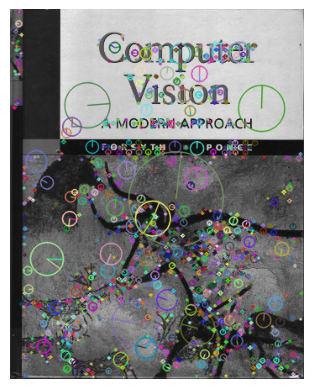

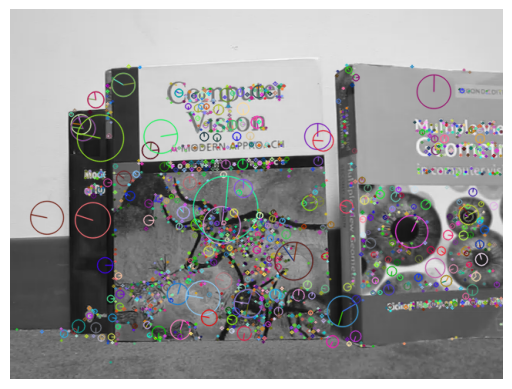

In [2]:
# Read images and use SIFT to detect keypoints
# Book cover image
img = read_image_rgb('data/cv_cover.jpg')
gray = RGB2GRAY(img)

sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

img_keypoints = read_image_rgb('data/cv_cover.jpg')
img_keypoints = cv.drawKeypoints(gray, kp, img_keypoints, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv.imwrite('data/sift_keypoints.jpg', img_keypoints)
show_image(img_keypoints)

# First video frame
video = read_video('data/book.mov')
video_gray = RGB2GRAY(video[0])

video_sift = cv.SIFT_create()
kp_video, des_video = video_sift.detectAndCompute(video_gray, None)

img_video_keypoints = read_video('data/book.mov')[0]
img_video_keypoints = cv.drawKeypoints(video_gray, kp_video, img_video_keypoints, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv.imwrite('data/sift_keypoints_video.jpg', img_video_keypoints)
show_image(img_video_keypoints)

Number of matches: 346


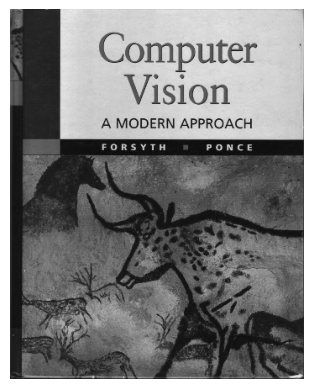

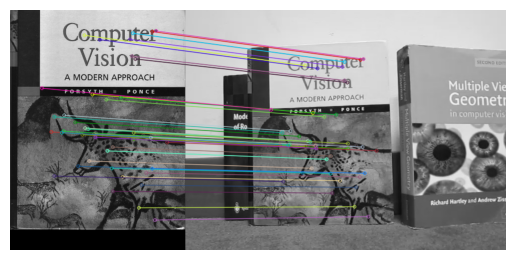

In [3]:
# Find correspondences using CV BFMatcher
bf = cv.BFMatcher()
matches = bf.knnMatch(des, des_video, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good.append([m])
        
# Pick the best 50 matches
print(f"Number of matches: {len(good)}")
good = sorted(good, key=lambda x: x[0].distance)[:50]

# Draw matches
img_matches = cv.drawMatchesKnn(img, kp, video_gray, kp_video, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show_image(img)
show_image(img_matches)

## 1.2  Homography Parameters

Now, we compute the 3x3 homography matrix H using a set of corresponding image points

In [4]:
# Compute homography
H = compute_homography(good, kp, kp_video)
print("Homography matrix H:")
print(H)

Homography matrix H:
[[ 7.81204735e-01  4.32575988e-03  1.18669191e+02]
 [-4.76521236e-02  7.83667287e-01  7.66540224e+01]
 [-7.63425698e-05 -7.10190690e-05  1.00000000e+00]]


In [5]:
def map_point(H, p):
    """
    A function that takes a homography matrix H and a point p
    and returns the corresponding point p' in the second view.
    
    :param H: Homography matrix.
    :param p: Point in the first view (2D).
    :return: Point in the second view (2D).
    """
    p_h = np.array([p[0], p[1], 1])
    p_prime_h = H @ p_h
    if p_prime_h[2] != 0:
        p_prime_h[0] = p_prime_h[0] / p_prime_h[2]
        p_prime_h[1] = p_prime_h[1] / p_prime_h[2]
    return (p_prime_h[0], p_prime_h[1])

Validate H

In [6]:
def map_clicked_point(H, img1, img2):
    """
    Map a clicked point from img1 to img2 using a homography, showing both images
    side-by-side in a composite window.
        
    :param H: 3x3 Homography matrix.
    :param img1: First image (source).
    :param img2: Second image (destination).
    """
    # Clone the images so the originals remain unchanged
    img1_clone = img1.copy()
    img2_clone = img2.copy()
    
    # Resize img2 to match the height of img1
    height1, width1 = img1_clone.shape[:2]
    height2, width2 = img2_clone.shape[:2]
    scale = 1.0  # default scale factor is 1 if no resizing is needed
    if height1 != height2:
        scale = height1 / height2
        new_width2 = int(width2 * scale)
        img2_clone = cv.resize(img2_clone, (new_width2, height1))
    
    # The offset for img2 in the composite image
    img1_width = width1

    # Function to show the composite image
    def show_composite():
        composite = np.hstack([img1_clone, img2_clone])
        cv.imshow("Composite Image", composite)
    
    # Mouse callback for the composite window
    def on_mouse_click(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            # Only process clicks in the first image
            if x < img1_width:
                # Draw a circle on img1_clone at the clicked point
                cv.circle(img1_clone, (x, y), 5, (0, 0, 255), -1)
                
                # Map the clicked point using the homography
                # p1 is in the coordinate system of img1
                p1 = [x, y]
                p2_original = map_point(H, p1)  # p2 in img2's original coordinates

                # Adjust the mapped point according to the scaling applied to img2
                x2 = int(p2_original[0] * scale)
                y2 = int(p2_original[1] * scale)
                
                # Draw a circle in the resized second image
                cv.circle(img2_clone, (x2, y2), 5, (0, 255, 0), -1)
                
                # Create the composite image and draw the connecting line
                composite = np.hstack([img1_clone, img2_clone])
                # The second image is offset by img1_width
                cv.line(composite, (x, y), (x2 + img1_width, y2), (255, 0, 0), 2)
                cv.imshow("Composite Image", composite)
    
    # Create composite window and set the mouse callback
    cv.namedWindow("Composite Image")
    cv.setMouseCallback("Composite Image", on_mouse_click)
    
    # Show the initial composite image
    show_composite()
    
    # Wait for a key press and then clean up windows
    cv.waitKey(0)
    cv.setMouseCallback("Composite Image", lambda *args: None)
    cv.destroyAllWindows()

# Assuming H, img1, and img2 are already defined
map_clicked_point(H, img, video[0])   

## 1.3  Calculate Book Coordinates

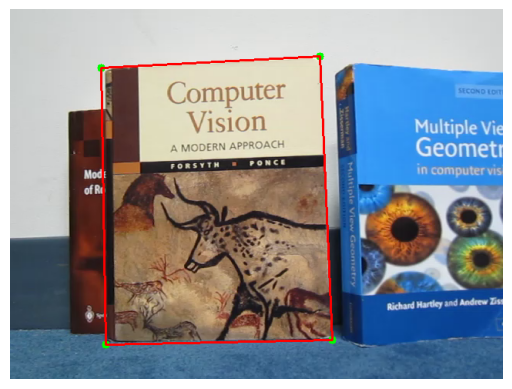

In [7]:
def get_video_book_corners(H, book_img):
    """
    Get the corners of the book in the video frame using the homography matrix.
    
    :param H: 3x3 Homography matrix.
    :param img1: First image (source).
    :param img2: Second image (destination).
    :return: List of points representing the corners of the book in the video frame.
    """
    # Define the corners of the book cover in the first image
    h, w = book_img.shape[:2]
    corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners = np.zeros((4, 1, 2), dtype=np.float32)
    
    # Transform corners using the homography matrix
    for i in range(4):
        corner = corners[i][0]
        # Map the corner point using the homography matrix
        transformed_corner = map_point(H, corner)
        transformed_corners[i][0] = transformed_corner
    
    return transformed_corners

transformed_corners = get_video_book_corners(H, img)
# Draw the transformed corners on the video frame
video_frame = video[0].copy()
for corner in transformed_corners:
    cv.circle(video_frame, (int(corner[0][0]), int(corner[0][1])), 5, (0, 255, 0), -1)
# Draw lines connecting the corners
for i in range(4):
    start_point = transformed_corners[i][0]
    end_point = transformed_corners[(i + 1) % 4][0]
    cv.line(video_frame, (int(start_point[0]), int(start_point[1])), (int(end_point[0]), int(end_point[1])), (255, 0, 0), 2)
# Show the video frame with the transformed corners
show_image(video_frame)

## 1.4  Crop AR Video Frames

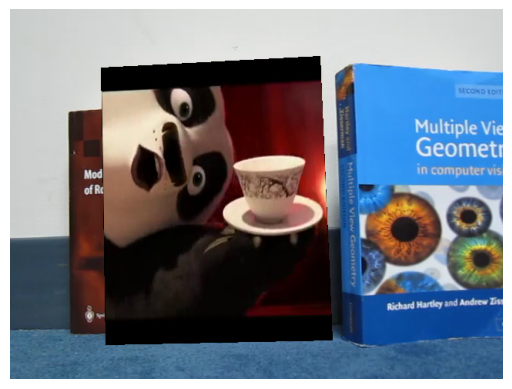

In [8]:
def crop_video_frame(book_img, video_frame):
    """
    Crop the video frame to fit onto the book cover in the book video
    frame. The frame is cropped such that only its central region is
    used in the overlayed frame.
    :param book_img: Book cover image.
    :param video_frame: Video frame.
    :return: Cropped video frame.
    """
    # Get the dimensions of the book cover
    book_h, book_w = book_img.shape[:2]
    
    # Resize the video frame to 640x480
    video_frame = cv.resize(video_frame, (640, 480))

    # Get the dimensions of the video frame
    video_h, video_w = video_frame.shape[:2]
    
    # Calculate the cropping margins to center-crop the video frame
    top = max(0, (video_h - book_h) // 2)
    bottom = top + book_h
    left = max(0, (video_w - book_w) // 2)
    right = left + book_w
    
    # Crop the video frame
    cropped_video_frame = video_frame[top:bottom, left:right]
    
    return cropped_video_frame

def overlay_frames(H, book_frame, cropped_frame, transformed_corners):
    """
    Overlay the cropped video frame onto the book cover in the book video frame.
    
    :param H: Homography matrix.
    :param book_frame: Book video frame (destination frame).
    :param cropped_frame: Cropped video frame (source frame).
    :param transformed_corners: Transformed corners of the book in the video frame.
    :return: Overlayed frame.
    """
    # Convert transformed corners to a NumPy array
    transformed_corners = np.array(transformed_corners, dtype=np.float32)
    
    # Warp the cropped frame to fit the transformed corners
    warped_frame = cv.warpPerspective(cropped_frame, H, (book_frame.shape[1], book_frame.shape[0]))
    
    # Create a mask from the warped frame to blend it with the book frame
    mask = np.zeros_like(book_frame, dtype=np.uint8)
    cv.fillConvexPoly(mask, transformed_corners.astype(np.int32), (255, 255, 255))
    
    # Invert the mask to keep the original book frame where the warped frame is not present
    mask_inv = cv.bitwise_not(mask)
    
    # Combine the warped frame with the book frame
    book_frame_bg = cv.bitwise_and(book_frame, mask_inv)
    warped_frame_fg = cv.bitwise_and(warped_frame, mask)
    overlayed_frame = cv.add(book_frame_bg, warped_frame_fg)
    
    return overlayed_frame

# Crop the video frame
source_video = read_video('data/ar_source.mov')[400]
cropped_frame = crop_video_frame(img, source_video)
# Overlay the cropped frame onto the book video frame
transformed_corners = get_video_book_corners(H, img)
overlayed_frame = overlay_frames(H, video[0], cropped_frame, transformed_corners)
# Show the overlayed frame
show_image(overlayed_frame)


## 1.5  Create the AR Video

In [9]:
# Each video frame descriptor is computed using the SIFT algorithm
_book_video = read_video('data/book.mov')
_video_kps = []
_video_des = []
for _frame in _book_video:
    _kp_frame, _des_frame = compute_SIFT_kps_and_descriptors(_frame)
    _video_kps.append(_kp_frame)
    _video_des.append(_des_frame)

In [10]:
# Find correspondences between the book cover and each video frame
_matches = []
_book_cover_image = read_image('data/cv_cover.jpg')
_book_cover_gray = RGB2GRAY(_book_cover_image)
_book_cover_sift = cv.SIFT_create()
_book_cover_kps, _book_cover_des = _book_cover_sift.detectAndCompute(_book_cover_gray, None)
for i in range(len(_video_des)):
    _good = get_top_correspondences(_book_cover_des, _video_des[i], 50)
    _matches.append(_good)
    
print(len(_matches))
print(len(_book_video))

641
641


In [11]:
# Compute the homography matrix for each video frame
_homographies = []
for i in range(len(_matches)):
    _H = compute_homography(_matches[i], _book_cover_kps, _video_kps[i])
    if i < 5:
        print(_H)
    _homographies.append(_H)
    
print(len(_homographies))


[[ 7.81204735e-01  4.32575988e-03  1.18669191e+02]
 [-4.76521236e-02  7.83667287e-01  7.66540224e+01]
 [-7.63425698e-05 -7.10190690e-05  1.00000000e+00]]
[[ 7.75292776e-01  3.29723510e-03  1.19359900e+02]
 [-5.05463220e-02  7.80637574e-01  7.72616484e+01]
 [-8.72274093e-05 -7.25007579e-05  1.00000000e+00]]
[[ 7.71111952e-01  4.13357586e-03  1.19415523e+02]
 [-5.37324836e-02  7.79731031e-01  7.77192607e+01]
 [-1.00719491e-04 -6.88384290e-05  1.00000000e+00]]
[[ 7.68954430e-01  3.29159051e-03  1.19609241e+02]
 [-5.53189313e-02  7.77949413e-01  7.80002692e+01]
 [-1.04613058e-04 -7.23481800e-05  1.00000000e+00]]
[[ 7.71039376e-01  6.02804755e-03  1.19230784e+02]
 [-5.50606005e-02  7.81787460e-01  7.77444136e+01]
 [-1.03814917e-04 -6.24578203e-05  1.00000000e+00]]
641


In [12]:
# For each book video frame:
# 1. Crop the corresponding video frame to fit the book cover
# 2. Overlay the cropped frame onto the book video frame
# 3. Append the resulting frame to a list
_source_video = read_video('data/ar_source.mov')
_ar_frames = []
for i in range(len(_book_video)):
    # Crop the video frame
    _source_frame = _source_video[i%len(_source_video)]
    _cropped_frame = crop_video_frame(_book_cover_image, _source_frame)
    
    # Overlay the cropped frame onto the book video frame
    _transformed_corners = get_video_book_corners(_homographies[i], _book_cover_image)
    if i < 3:
        print(_transformed_corners)
    _overlayed_frame = overlay_frames(_homographies[i], _book_video[i], _cropped_frame, _transformed_corners)
    
    # Append the overlayed frame to the list
    _ar_frames.append(_overlayed_frame)
print(len(_ar_frames))


[[[118.66919   76.65402 ]]

 [[402.8551    61.622322]]

 [[418.23877  429.69827 ]]

 [[124.461754 435.06262 ]]]
[[[119.3599   77.26165]]

 [[403.0163   61.44637]]

 [[418.2761  429.88892]]

 [[124.79157 434.60626]]]
[[[119.41552   77.71926 ]]

 [[403.52988   61.065563]]

 [[418.55594  430.18948 ]]

 [[125.02105  433.9446  ]]]
641


In [13]:
# Save the augmented reality frames as a video with mov extension
fourcc = cv.VideoWriter_fourcc(*'mp4v')
out = cv.VideoWriter('data/ar_output.mov', fourcc, 30.0, (640, 480))
for frame in _ar_frames:
    out.write(frame)
out.release()